# Binomial options pricing model

This is a notebook about the Binomial Options Pricing model. Our main reference is "Introduction to the Mathematics of Finance" by Steven Roman (2nd Edition, Springer, 2012).



## Formulation

Variables:

* $S_0$ is the initial value of the stock
* $u$ is the up-tick factor
* $d$ is the down-tick factor
* $r$ is the (constant) annualized risk-free interest rate
* $K$ is the strike price of an option
* $T$ is the number of time intervals
* $\Delta t$ is the size of a single time interval in years

For a real number $x$, let $(x)^+ = \mathrm{ReLU}(x) = \mathrm{max}(0,x)$. The initial value of a call option (resp. put option) with strike price $K$ and expiry date after $T \Delta t$ units of time is given by:

$$ \mathcal I_0(\mathrm{call}) = e^{-rT\Delta t} \sum_{k=0}^T { n \choose k} \left( S_0 u^k d^{T-k} - K\right)^+ \pi^k (1-\pi)^{T-k},$$

$$ \mathcal I_0(\mathrm{put}) = e^{-rT\Delta t} \sum_{k=0}^T { n \choose k} \left( K - S_0 u^k d^{T-k} \right)^+ \pi^k (1-\pi)^{T-k},$$

where $\pi$ is the risk-free (or martingale) up-tick probability, and is given by 

$$\pi = \frac{e^{r\Delta t} - d}{u-d}.$$

The model is free of arbitrage if and only if $d < e^{r \Delta t} < u$. We also have: $1-\pi = \frac{u - e^{r \Delta t}}{u-d}$. Note that the actual, real-world probability of an up-tick or down-tick are not relevant for computing the initial value of a call option. We also note the put-call parity formula:

$$\mathcal I_0(\mathrm{put}) - \mathcal I_0(\mathrm{call}) =  e^{-rT\Delta t} K - S_0$$



## Implementation

In [1]:
from math import exp
import matplotlib.pyplot as plt

In [2]:
# Choose function
def choose(k, n):
    a = 1
    for i in range(k):
        a *= (n-i)/(i+1)
    return a

# ReLU
def relu(x):
    return max(0,x)

# Martingale probability
def martingale_prob(up_tick, down_tick, interest_rate, time_interval):
    interest = exp(interest_rate*time_interval)
    assert down_tick < interest and interest < up_tick, "There is no probability eliminating arbitrage"
    return (interest - down_tick)/(up_tick-down_tick)

# Initial option price
def initial_price(
        up_tick, 
        down_tick, 
        spot, 
        strike, 
        time_interval=1, 
        num_intervals=1, 
        interest_rate=0.0, 
        option_type="call"
    ):
    assert option_type == "call" or option_type == "put", "Invalid option type; must be 'call' or 'put'"
    pi = martingale_prob(up_tick=up_tick,down_tick=down_tick, interest_rate=interest_rate, time_interval=time_interval)
    answer = 0
    for k in range(num_intervals+1):
        Sfinal = spot*(up_tick**k)*(down_tick**(num_intervals-k))
        probability = (pi**k)*((1-pi)**(num_intervals-k))
        if option_type == "call":
            answer += choose(k,num_intervals)*relu(Sfinal - strike)*probability
        else:
            answer += choose(k,num_intervals)*relu(strike - Sfinal)*probability
    discount_factor = exp(-interest_rate*time_interval*num_intervals)
    return discount_factor*answer


## Example of pricing using the binomial model

The following example appears in Chapter 6 of *Introduction to the Mathematics of Finance* by Steven Roman, 2nd Edition, Springer, 2012.

"A certain stock is currently selling for $\$100 $. The feeling is that for each month over the next two months, the stock's price will rise by $1\%$ or fall by $1\%$.Assuming a risk-free rate of $1\%$, calculate the price of a European call with the various strike prices $K = 102$, $K=101$, $K=100$, $K=99$, $K=98$, and $K=97$."

We provide a solution based on the functions above, checking that the put-call parity formula holds:

In [3]:
print(f"Up-tick martingale probability: {round(martingale_prob(up_tick=1.01, down_tick=0.99, interest_rate =0.01/12, time_interval=1), 4)}\n")

for K in [102,101, 100, 99, 98, 97]:
    call_price = initial_price(
            up_tick=1.01, 
            down_tick=0.99, 
            spot=100, 
            strike=K, 
            time_interval=1/12, 
            num_intervals=2, 
            interest_rate=0.01
        )
    put_price = initial_price(
            up_tick=1.01, 
            down_tick=0.99, 
            spot=100, 
            strike=K, 
            time_interval=1/12, 
            num_intervals=2, 
            interest_rate=0.01, 
            option_type="put"
        )
    price_of_forward =  K*exp(-(2/12)*(0.01)) -100
    assert abs(put_price - call_price - price_of_forward) < 1e-5, "put-call parity is violated!"
    print(f"Price of {K}-call : \t {round(call_price,4)}")
    print(f"Price of {K}-put : \t {round(put_price,4)}")
    print(f"Price of {K}-forward : \t {round(price_of_forward,4)}\n")

Up-tick martingale probability: 0.5417

Price of 102-call : 	 0.0029
Price of 102-put : 	 1.8331
Price of 102-forward : 	 1.8301

Price of 101-call : 	 0.2959
Price of 101-put : 	 1.1277
Price of 101-forward : 	 0.8318

Price of 100-call : 	 0.5888
Price of 100-put : 	 0.4223
Price of 100-forward : 	 -0.1665

Price of 99-call : 	 1.3725
Price of 99-put : 	 0.2076
Price of 99-forward : 	 -1.1649

Price of 98-call : 	 2.1632
Price of 98-put : 	 0.0
Price of 98-forward : 	 -2.1632

Price of 97-call : 	 3.1615
Price of 97-put : 	 0.0
Price of 97-forward : 	 -3.1615



We make a plot of these option prices.

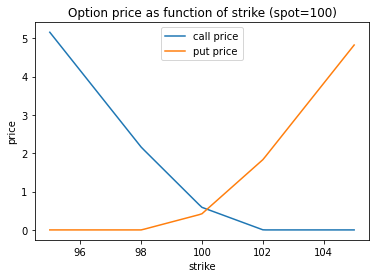

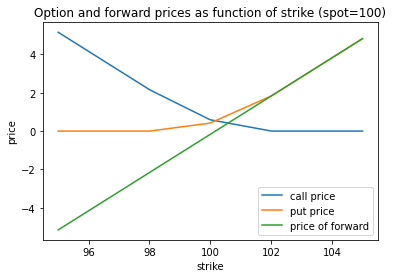

In [4]:
min_strike, max_strike = 95, 105
num_samples = 100
step_size = (max_strike - min_strike)/num_samples

strikes = [min_strike + i*step_size for i in range(num_samples+1)]
call_prices = [initial_price(
    up_tick=1.01, 
    down_tick=0.99, 
    spot=100, 
    strike=K, 
    time_interval=1/12, 
    num_intervals=2, 
    interest_rate=0.01
) for K in strikes]
put_prices = [initial_price(
    up_tick=1.01, 
    down_tick=0.99, 
    spot=100, 
    strike=K, 
    time_interval=1/12, 
    num_intervals=2, 
    interest_rate=0.01, 
    option_type="put"
) for K in strikes]
forward_prices = [K*exp(-2*(0.01/12)) -100 for K in strikes]

plt.plot(strikes, call_prices, label="call price")
plt.plot(strikes, put_prices, label="put price")
plt.xlabel("strike")
plt.ylabel("price")
plt.title("Option price as function of strike (spot=100)")
plt.legend()
plt.show()

plt.cla()
plt.plot(strikes, call_prices, label="call price")
plt.plot(strikes, put_prices, label="put price")
plt.plot(strikes, forward_prices, label="price of forward")
plt.xlabel("strike")
plt.ylabel("price")
plt.title("Option and forward prices as function of strike (spot=100)")
plt.legend()
plt.show()

## Limit of binomial option pricing model

We now explore the behavior of the binomial model as one decreases the interval size. We do this throuby continuing the above example. 

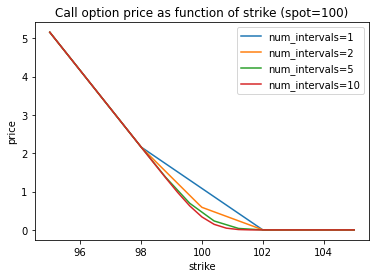

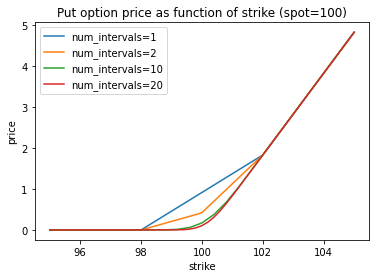

In [5]:
min_strike, max_strike = 95, 105
num_samples = 100
step_size = (max_strike - min_strike)/num_samples

strikes = [min_strike + i*step_size for i in range(num_samples+1)]
for i in [1,2,5,10]:
    call_prices_i = [initial_price(
            up_tick=1+ (1.02 -1)/i, 
            down_tick=1 - (1-0.98)/i, 
            spot=100, 
            strike=K, 
            time_interval=(2/12)/i, 
            num_intervals=i, 
            interest_rate=0.01
        ) for K in strikes]
    plt.plot(strikes, call_prices_i, label=f"num_intervals={i}")
plt.xlabel("strike")
plt.ylabel("price")
plt.title("Call option price as function of strike (spot=100)")
plt.legend()
plt.show()


plt.cla()
for i in [1,2,10,20]:
    put_prices_i = [initial_price(
            up_tick=1+ (1.02 -1)/i, 
            down_tick=1 - (1-0.98)/i, 
            spot=100, 
            strike=K, 
            time_interval=(2/12)/i, 
            num_intervals=i, 
            interest_rate=0.01, 
            option_type='put'
        ) for K in strikes]
    plt.plot(strikes, put_prices_i, label=f"num_intervals={i}")

plt.xlabel("strike")
plt.ylabel("price")
plt.title("Put option price as function of strike (spot=100)")
plt.legend()
plt.show()


## Relation with Black-Scholes-Merton option pricing formula

Let $\sigma$ be the volatility. Then the binomial model with $u = e^{\sigma \sqrt{\Delta t}}$ and $d = u^{-1} = e^{-\sigma \sqrt{\Delta t}}$ limits to the Black0Scholes pricing model as the time intervals $\Delta t$ become smaller. This is based on the paper *Option pricing: A simplified approach* by Cox, Ross, and Rubinstein (Journal of Financial Economics (1979). 7 (3): 229).

In [6]:
import scipy.stats
from scipy.stats import norm
from math import log, sqrt

Norm = scipy.stats.norm.cdf

def black_scholes(
        spot, 
        strike, 
        volatility, 
        time_to_expiry,
        interest_rate=0.0, 
        option_type = "call"
    ):
    assert option_type == "call" or option_type == "put", "Invalid option type; must be 'call' or 'put'"
    dplus = (log(spot/strike) + (interest_rate + (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    dminus = (log(spot/strike) + (interest_rate - (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    if option_type == "call":
        return spot*Norm(dplus) - strike*exp(-interest_rate*time_to_expiry)*Norm(dminus)
    else:
        return strike*exp(-interest_rate*time_to_expiry)*Norm(-dminus) - spot*Norm(-dplus)

def implied_volatility_from_uptick(up_tick, time_interval):
    return log(up_tick)/sqrt(time_interval)

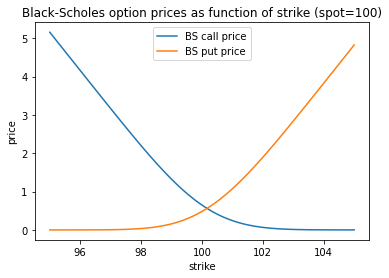

In [7]:
min_strike, max_strike = 95, 105
num_samples = 100
step_size = (max_strike - min_strike)/num_samples

strikes = [min_strike + i*step_size for i in range(num_samples+1)]
bsm_call_prices = []
bsm_put_prices = []
for K in strikes:
    bsm_call = black_scholes(
        spot=100,
        strike= K,
        volatility=implied_volatility_from_uptick(up_tick=1.01, time_interval=1/12), 
        interest_rate=0.01,
        time_to_expiry=2/12
    )
    bsm_put = black_scholes(
        volatility=implied_volatility_from_uptick(up_tick=1.01, time_interval=1/12),
        spot=100,
        strike=K,
        interest_rate=0.01,
        option_type="put",
        time_to_expiry=2/12
    )
    price_of_forward = K*exp(-2*(0.01/12)) -100
    assert abs(bsm_put - bsm_call - price_of_forward) < 1e-3 
    bsm_call_prices.append(bsm_call)
    bsm_put_prices.append(bsm_put)

plt.plot(strikes, bsm_call_prices, label="BS call price")
plt.plot(strikes, bsm_put_prices, label="BS put price")
plt.xlabel("strike")
plt.ylabel("price")
plt.title("Black-Scholes option prices as function of strike (spot=100)")
plt.legend()
plt.show()

In [8]:
def compare_models(
            num_intervals, 
            time_to_expiry, 
            volatility, 
            spot, 
            interest_rate, 
            num_strike_samples=5,
            precision = 1e-3,
            option_type = "call"
        ):
    assert option_type == "call" or option_type == "put", "Invalid option type; must be 'call' or 'put'"
    min_strike, max_strike = spot*0.8, spot*1.2
    step_size = (max_strike - min_strike)/num_strike_samples
    strikes = [min_strike + i*step_size for i in range(num_strike_samples+1)]

    time_interval_size =time_to_expiry/num_intervals 
    up_tick_crr = exp(volatility*sqrt(time_interval_size))
    down_tick_crr = exp(-volatility*sqrt(time_interval_size))
    for K in strikes:
        binomial_price = initial_price(
            up_tick=up_tick_crr, 
            down_tick=down_tick_crr, 
            spot=spot, 
            strike=K, 
            time_interval=time_interval_size,
            num_intervals=num_intervals, 
            interest_rate=interest_rate,
            option_type=option_type
        ) 
        bsm_price = black_scholes(
            spot=spot, 
            strike=K, 
            volatility=volatility, 
            interest_rate = interest_rate, 
            time_to_expiry=time_to_expiry, 
            option_type=option_type   
        ) 
        if abs(binomial_price-bsm_price) > precision:
            print(f"Models do not match on strike {K}. \nTake a larger number of intervals")
            return False
    print(f"Models match up to {precision} on these options!")
    return True

In [9]:
compare_models(
    spot=100, 
    time_to_expiry=2/12, 
    num_intervals=500, 
    volatility=0.1, 
    interest_rate=0.1,
    precision=1e-3
)

compare_models(
    spot=100, 
    time_to_expiry=2/12, 
    num_intervals=500, 
    volatility=0.1, 
    interest_rate=0.1,
    precision=1e-3,
    option_type="put"
)

Models match up to 0.001 on these options!
Models match up to 0.001 on these options!


True